In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Classificação usando Naive Bayes


### Import Dependencies

In [ ]:
!pip install scikit-plot

In [ ]:
import pandas as pd
import numpy as np
from google.colab import data_table
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

### Import DataSet

In [98]:


labels = ["intercolumnar distance","upper margin","lower margin","exploitation","row number","modular ratio","interlinear spacing","weight","peak number","modular ratio/ interlinear spacing","Class"]


path_dataset_tr = "/content/drive/MyDrive/AM/data/avila-tr.txt"
path_dataset_ts = "/content/drive/MyDrive/AM/data/avila-ts.txt"

avila_tr = pd.read_csv(path_dataset_tr, sep=",",header=None,names=labels)
avila_tr

avila_ts = pd.read_csv(path_dataset_ts, sep=",",header=None,names=labels)

x_tr = avila_tr.drop("Class", axis = 1)
y_tr = avila_tr["Class"].values

x_ts = avila_ts.drop("Class", axis = 1)
y_ts = avila_ts["Class"].values


### Analisando dataset

Os classificadores Naive Bayes levam mão da seguinte modificação do teorema de Bayes 

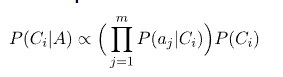


Isso significa que assumimos a indepêndencia entre as features (naive). Dessa forma, primeiro precisaremos tratar o dataset caso exista correlação entre as classes. Para realizar essa analise iremos utilizar um clustermap.

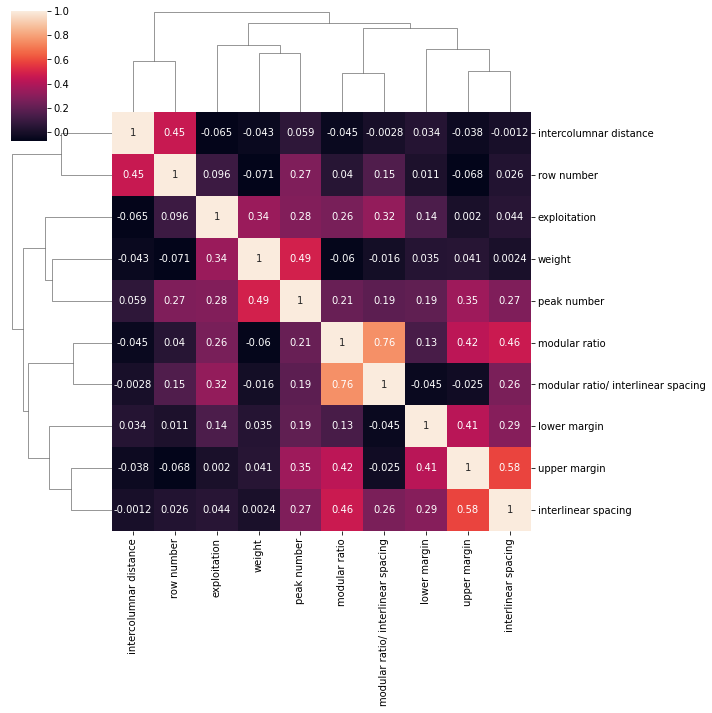

In [104]:
correlations = avila_tr.corr()
sns.clustermap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True)

Assim, as features do dataset não são linearmente correlacionadas e por isso não será necessário tratamento.

### Escolha do Classificador

Existem os seguintes classificadores Naive Bayes no scikit: 
- Gaussian
- Bernoulli
- Categorical
- Complement
- Multinomial

O classificador selecionado foi o Gaussian já que ele é apropriado para dados continuos, enquanto os outros são para outros tipos de dados (e.g. discreto, binário, etc...)

Entretanto, é importante observar que dada a natureza do Naive Bayes ele irá ter um baixo desempenho em datasets desbalanceados que é o caso do Avila. 

## Naive Bayes (Gaussian)

### Modelo Padrão

Primeiro treinaremos o modelo Gaussian com os valores padrões para determinar uma base que será utilizadas afim de comparar resultados e buscar melhorias.

In [122]:
gauss = GaussianNB()
gauss.fit(x_tr, y_tr)
pred = gauss.predict(x_ts) # Predizendo os dados de teste

#### Analise do modelo

##### Scores

In [123]:
target_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'W','X', 'Y']
report = classification_report(y_ts, pred, target_names=target_names, digits=4)
print(report)

              precision    recall  f1-score   support

           A       0.51      0.06      0.11      4286
           B       1.00      1.00      1.00         5
           C       0.05      0.08      0.06       103
           D       0.15      0.24      0.19       353
           E       0.26      0.09      0.13      1095
           F       0.29      0.42      0.34      1962
           G       0.15      0.70      0.25       447
           H       0.22      0.82      0.34       520
           I       0.72      0.68      0.70       832
           W       0.12      0.51      0.20        45
           X       0.46      0.66      0.55       522
           Y       0.46      0.38      0.42       267

    accuracy                           0.29     10437
   macro avg       0.37      0.47      0.36     10437
weighted avg       0.41      0.29      0.25     10437



No geral nota-se o baixo desempenho do modelo em relação a todos os scores (Precision, Recall, F1-score). 
Macro Average: 
- Precision = 0.37
- Recall = 0.47
- F1-Score = 0.36

Além disso, notasse uma grande disparidade entre os scores de cada classe.
- Para a classe A o precision é de 0.51 enquanto o recall e f1-score são relativamente menores, 0.06 e 0.11 respectivamente.
- Classes como I e B tiveram scores altos em relação a média dos scores das classes, mas para classes como a C desempenharam mal.



##### Matriz de Confusão

A matriz de confusão a seguir demonstra como o modelo se comportou tentando prever o conjunto de teste. 

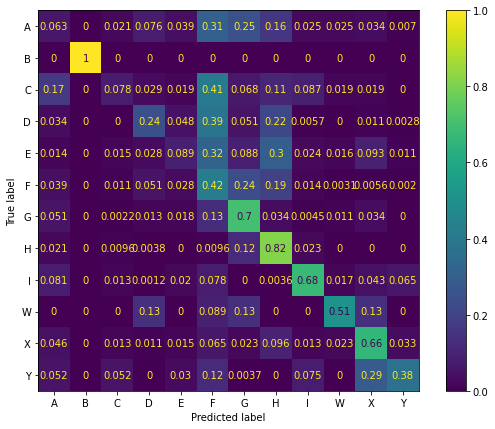

In [124]:
cm = confusion_matrix(y_ts, pred, labels=target_names, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)

fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(ax=ax)

plt.show()

Nota-se uma dificuldade do modelo em predizer corretamente algumas classes
* A classe A é frequentemente confundida com a F e a G. 
* A classe C é frquentemente confudida com a F.

Equanto teve uma acurácia relativamente melhor em outras, à exemplo das classes H e I.

Adjunto, o modelo tende a prever frequentemente um exemplo como sendo pertencente da classe F.

### Fine-Tunning


Para realizar o fine-tunning do modelo iremos tentar achar os melhores hyper-parâmetros cujo o desempenho dos scores( Precision, F1, Recall) seja máximo.

O Gaussian apenas possui um hyper-parâmetro que é ***var_smoothing***.

> **O var_smoothing** é um valor entre 0 e 1 e indica a parte da maior variância de todos as features que são adicionadas às variâncias afim de estabilidade de cálculo. Possui valor padrão de 1e-9.

Para fazer a busca do melhor var_smoothing é feita um grid_search que utiliza dentro de seu processo a validação cruzada. Assim evitamos a bias de tunning com dataset de teste.

In [105]:
search_space = np.linspace(1e-12,1, 10)
sc_scores_tr = []


gs = GridSearchCV(
    GaussianNB(),
    param_grid={'var_smoothing': search_space},
    scoring= ['precision_macro','recall_macro','f1_macro'],
    n_jobs=-1,
    refit=False,
    return_train_score=True,
    cv=5
)

gs.fit(x_tr,y_tr)


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e-12, 1.11111111e-01, 2.22222222e-01, 3.33333333e-01,
       4.44444444e-01, 5.55555556e-01, 6.66666667e-01, 7.77777778e-01,
       8.88888889e-01, 1.00000000e+00])},
             refit=False, return_train_score=True,
             scoring=['precision_macro', 'recall_macro', 'f1_macro'])

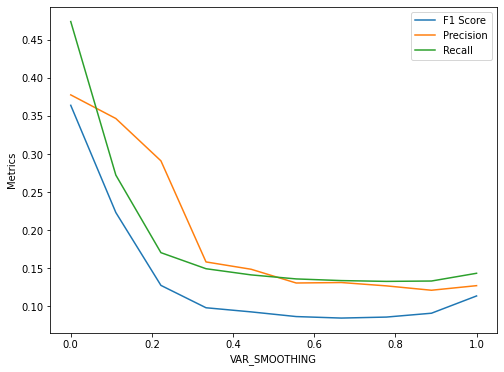

In [106]:
fig,ax = plt.subplots(figsize=(8,6))

ax.set_xlabel('VAR_SMOOTHING')
ax.set_ylabel('Metrics')

ax.plot(search_space, gs.cv_results_['mean_test_f1_macro'], label='F1 Score')
ax.plot(search_space, gs.cv_results_['mean_test_precision_macro'], label='Precision',)
ax.plot(search_space, gs.cv_results_['mean_test_recall_macro'], label='Recall',)

ax.legend()
plt.show()


É possível notar que todos os scores seguem a mesma tendência de piora inicial conforme o aumento do var_smoothing. 

É valido ressaltar que existe uma queda brusca para var_smoothing entre 0.0 e 0.2, seguida por uma estabilização para valores entre 0.2 e 0.9, para enfim ocorrer uma crescente de 0.9 a 1.0.

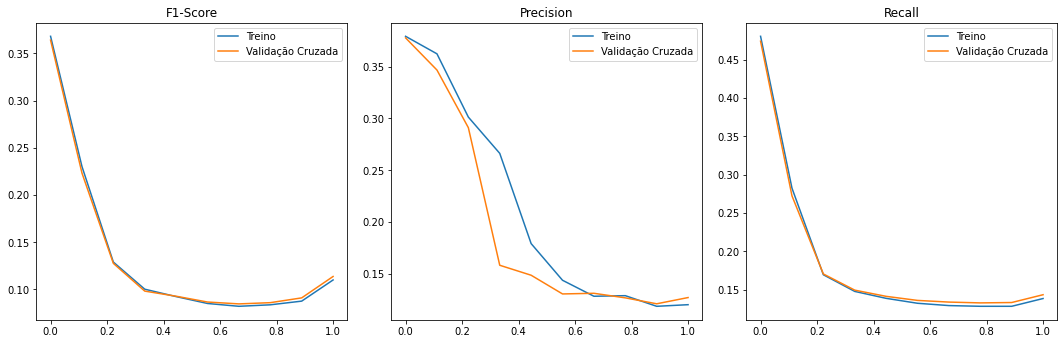

In [107]:
fig,ax = plt.subplots(1,3, figsize=(15,5))

ax[0].plot(search_space,gs.cv_results_['mean_train_f1_macro'])
ax[0].plot(search_space,gs.cv_results_['mean_test_f1_macro'])

ax[1].plot(search_space,gs.cv_results_['mean_train_precision_macro'])
ax[1].plot(search_space,gs.cv_results_['mean_test_precision_macro'])

ax[2].plot(search_space,gs.cv_results_['mean_train_recall_macro'])
ax[2].plot(search_space,gs.cv_results_['mean_test_recall_macro'])

for i in range(0,3):
  ax[i].legend(('Treino','Validação Cruzada'))

ax[0].set_title('F1-Score')
ax[1].set_title('Precision')
ax[2].set_title('Recall')

fig.tight_layout(pad=1.5)
plt.show()  

Observando os gráficos vemos que não ocorre overfitting. 

Além disso, observamos também que quanto mais próximo de 0 é o var_smoothing, maior são os scores. 



#### Modelo Otimizado

Assim para realizar o fine-tunning do modelo selecionaremos 1e-12 já que esse é o melhor valor do processo de grid search.

In [108]:
bestGaus = GaussianNB(var_smoothing=1e-12)
bestGaus.fit(x_tr, y_tr)
pred = bestGaus.predict(x_ts)

target_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'W','X', 'Y']
report = classification_report(y_ts, pred, target_names=target_names, digits=4)
print(report)

              precision    recall  f1-score   support

           A       0.51      0.06      0.11      4286
           B       1.00      1.00      1.00         5
           C       0.05      0.08      0.06       103
           D       0.15      0.24      0.19       353
           E       0.26      0.09      0.13      1095
           F       0.29      0.42      0.34      1962
           G       0.15      0.70      0.25       447
           H       0.22      0.82      0.34       520
           I       0.72      0.68      0.70       832
           W       0.12      0.51      0.20        45
           X       0.46      0.66      0.55       522
           Y       0.46      0.38      0.42       267

    accuracy                           0.29     10437
   macro avg       0.37      0.47      0.36     10437
weighted avg       0.41      0.29      0.25     10437



É possível notar a melhoria, apesar que mínima, em todos os scores quando comparado com o modelo padrão. 

É valido ressaltar que o naive bayes não terá no geral um bom desempenho pois o dataset está desbalanceado.